# Support Vector Machines

## 1. Imports

Importem totes les llibreries necessàries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


## 2. Càrrega i preparació de dades

Carreguem les dades del dataset, eliminem les característiques redundants segons l'anàlisi exploratori, identifiquem les variables numèriques i les categòriques, i dividim el dataset en entrenament i validació.

In [2]:
df = pd.read_csv('trs_train.csv')

# Eliminació de variables identificades a l'anàlisi
variables_eliminar = ['patient_id', 'Glucose', 'Ki_whole_striatum', 
                      'Ki_associative_striatum', 'SUVRc_associative_striatum']
df = df.drop(columns=variables_eliminar, errors='ignore')

# Separar variable objectiu
X = df.drop(columns=['TRS'])
y = df['TRS']

# Identificar columnes numèriques i categòriques
categorical_columns = ['Sex', 'Ethnicity', 'Family_history', 'Prior_antipsychotics', 
                'CYP2D6_metabolic_phenotype', 'HLA_DRB1_04_02', 'HLA_B_15_02', 
                'HLA_A_31_01', 'Del_22q11_2_status']

numerical_columns = [col for col in X.columns if col not in categorical_columns]
print(f"Variables numèriques: {len(numerical_columns)}")
print(f"Variables categòriques: {len(categorical_columns)}")

# Divisió train-test (80-20) amb estratificació
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} mostres")
print(f"Test set: {X_test.shape[0]} mostres")
print(f"Distribució train: {y_train.value_counts().to_dict()}")
print(f"Distribució test: {y_test.value_counts().to_dict()}")

Variables numèriques: 13
Variables categòriques: 9

Train set: 7200 mostres
Test set: 1800 mostres
Distribució train: {0: 4930, 1: 2270}
Distribució test: {0: 1232, 1: 568}


## 3. Preprocessament

Pipeline complet de preprocessament.
Per a les característiques numèriques, imputem amb la funció `SimpleImputer` mitjanant la mediana. Escalem també amb la funció `StandardScaler`.
Per a les característiques categòriques, imputem amb la funció `SimpleImputer` el valor més frequent. Codifiquem amb `OneHotEncoder` per a un correcte funcionament del nostre model.

Cridem la funció `SVC` de sklearn, la implementació del nostre SVM. Afegim l'atribut `class_weight = 'balanced'` per al desbalanceig de la classe objectiu.

In [3]:
# Transformador per variables numèriques
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Transformador per variables categòriques
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# ColumnTransformer que combina ambdós
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

# Pipeline complert amb i SVM
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True, random_state=42, class_weight='balanced'))
])

## 4. Grid search amb cross validation

Fem una cerca per trobar els hiperparàmetres que maximitzen F1 score. Definim la graella de cerca amb C, gamma i kernel i realitzem un grid search amb validació creuada (5-fold CV).

Un cop acabada la cerca, imprimim la combinació d'hiperparàetres escollida i el valor d'F1-macro.

In [4]:
# Definir grilla de paràmetres
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__gamma': [0.001, 0.01, 0.1, 1],
    'classifier__kernel': ['rbf', 'linear']
}

# GridSearchCV amb validació creuada estratificada
grid_search = GridSearchCV(
    estimator=model_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

print("\n" + "="*70)
print("INICIANT GRID SEARCH AMB VALIDACIÓ CREUADA (5-fold)")
print("="*70)

grid_search.fit(X_train, y_train)

# 3.3. Millors paràmetres
print("\n" + "="*70)
print("MILLORS PARÀMETRES")
print("="*70)
print(f"Millors paràmetres: {grid_search.best_params_}")
print(f"Millor F1-macro (CV): {grid_search.best_score_:.4f}")


INICIANT GRID SEARCH AMB VALIDACIÓ CREUADA (5-fold)
Fitting 5 folds for each of 40 candidates, totalling 200 fits

MILLORS PARÀMETRES
Millors paràmetres: {'classifier__C': 0.1, 'classifier__gamma': 0.001, 'classifier__kernel': 'rbf'}
Millor F1-macro (CV): 0.5879


## 5. Avaluació del model

Un cop tenim el model preparat, procedim amb la seva validació en el conjunt de test.

Comencem imprimint el classification report, on podem analitzar les mètriques.

In [5]:
best_model = grid_search.best_estimator_

# Prediccions en test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*70)
print("AVALUACIÓ EN TEST")
print("="*70)

# Classification report
print("\nCLASSIFICATION REPORT:")
print(classification_report(y_test, y_pred))

# ROC-AUC
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nROC-AUC Score: {roc_auc:.4f}")


AVALUACIÓ EN TEST

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1232
           1       0.43      0.45      0.44       568

    accuracy                           0.64      1800
   macro avg       0.58      0.59      0.59      1800
weighted avg       0.64      0.64      0.64      1800


ROC-AUC Score: 0.6281


Continuem amb la visualització de la matriu de confusió i la corba ROC.

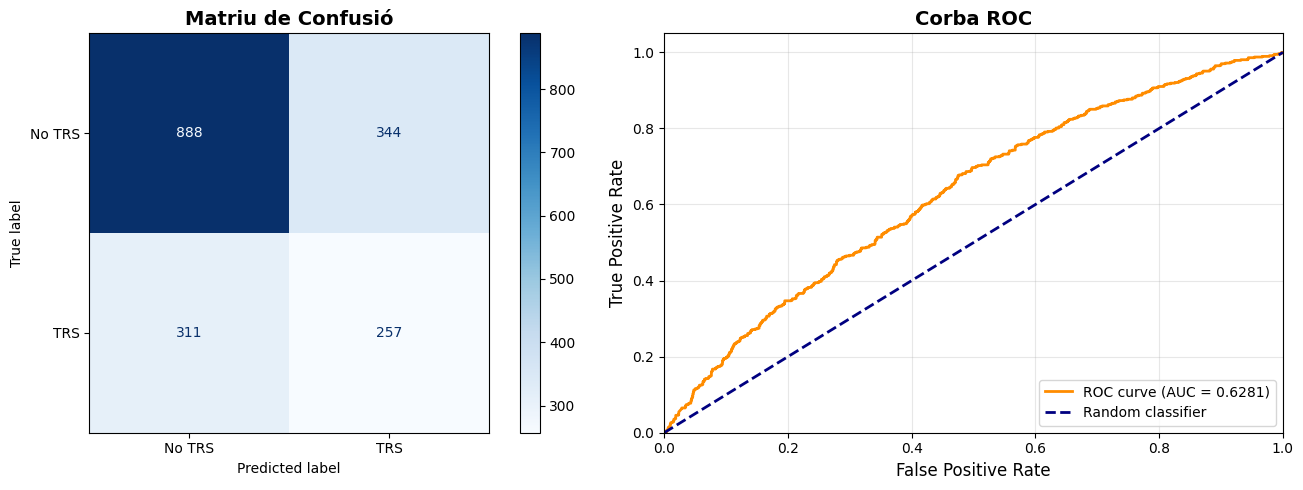

In [ ]:

cm = confusion_matrix(y_test, y_pred)
# Matriu de confusió visual
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                               display_labels=['No TRS', 'TRS'])
disp.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriu de Confusió', fontsize=14, fontweight='bold')

# Corba ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
             label='Random classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate', fontsize=12)
axes[1].set_ylabel('True Positive Rate', fontsize=12)
axes[1].set_title('Corba ROC', fontsize=14, fontweight='bold')
axes[1].legend(loc="lower right")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Visualitzem de forma gràfica la comparació de les diferents mètriques entre el conjunt d'entrenament i el de validació.


COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)
Mètrica                   Train        Test         Diferència  
----------------------------------------------------------------------
F1-Macro                       0.5938      0.5851      0.0087
F1-Binary (TRS)                0.4503      0.4397      0.0106
ROC-AUC                        0.6473      0.6281      0.0192
PR-AUC                         0.4419      0.4164      0.0255
Recall (TRS)                   0.4617      0.4525      0.0092
Precision (TRS)                0.4394      0.4276      0.0118
Balanced Accuracy              0.5952      0.5866      0.0086


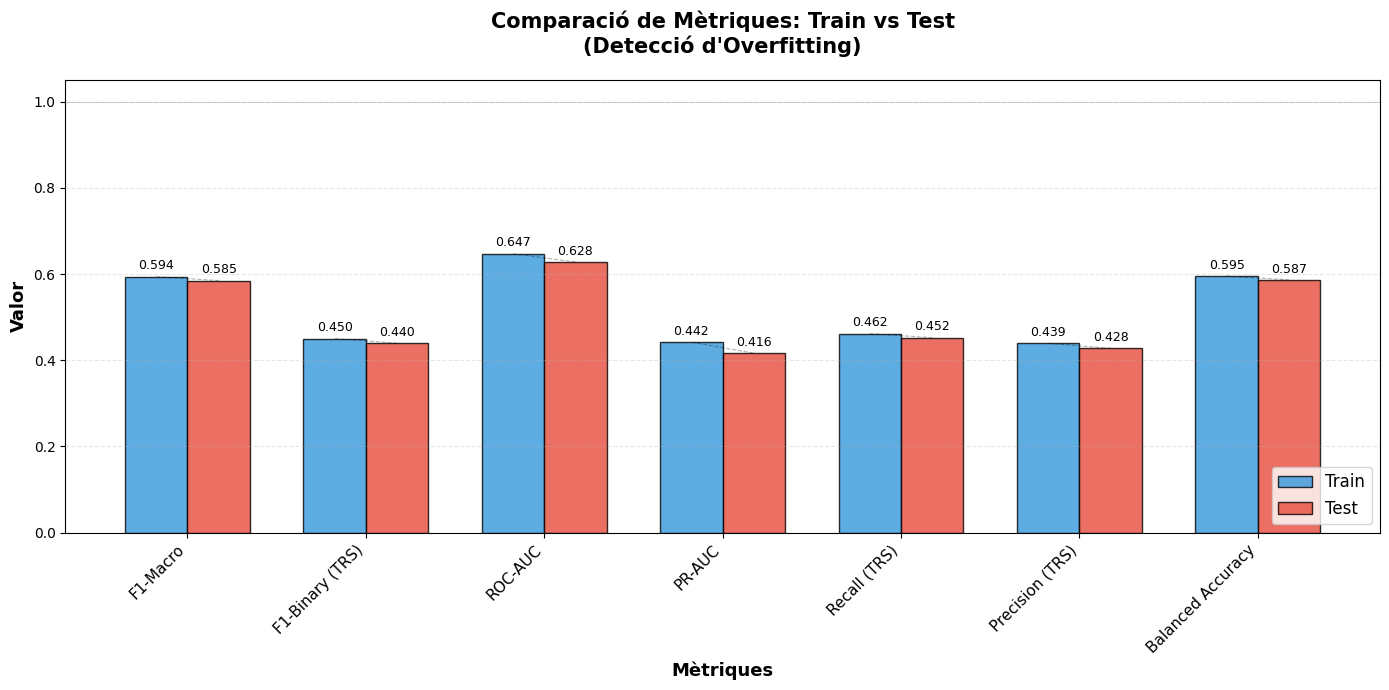

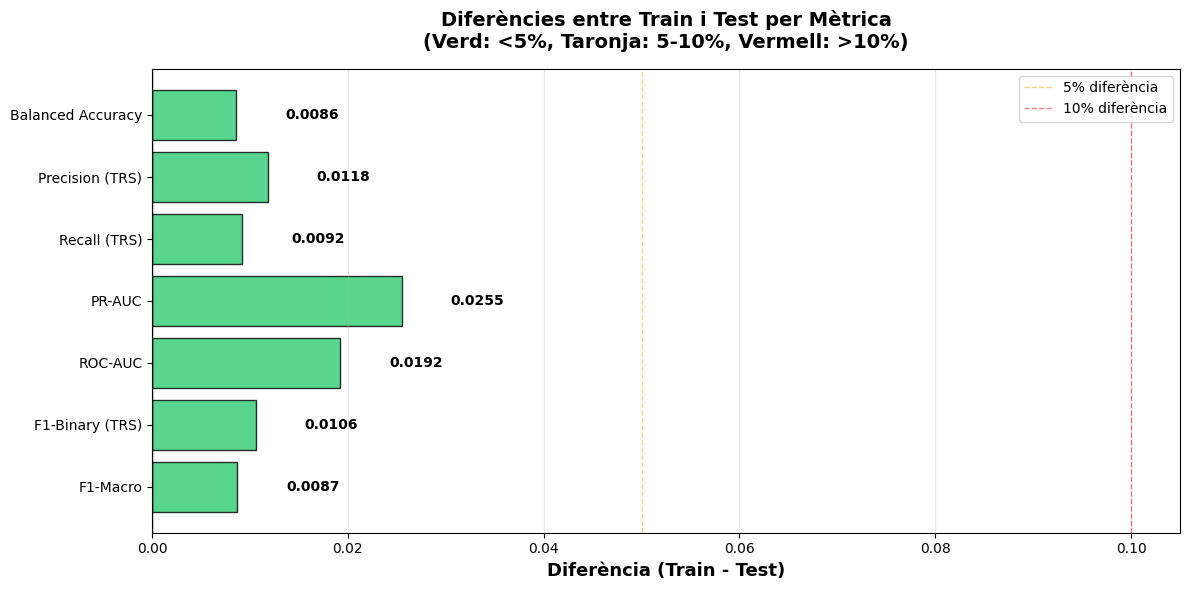


✓ Gràfics guardats: 'train_vs_test_metrics.png' i 'overfitting_analysis.png'


In [9]:
# Script per comparar mètriques entre train i test (detecció d'overfitting)

from sklearn.metrics import (f1_score, roc_auc_score, precision_score, 
                              recall_score, balanced_accuracy_score, 
                              average_precision_score)
import matplotlib.pyplot as plt
import numpy as np

# Calcular prediccions per al conjunt de train
y_train_pred = best_model.predict(X_train)
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

# Calcular prediccions per al conjunt de test (ja les tens)
y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular mètriques per train
train_metrics = {
    'F1-Macro': f1_score(y_train, y_train_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_train, y_train_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_train, y_train_pred_proba),
    'PR-AUC': average_precision_score(y_train, y_train_pred_proba),
    'Recall (TRS)': recall_score(y_train, y_train_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_train, y_train_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_train, y_train_pred)
}

# Calcular mètriques per test
test_metrics = {
    'F1-Macro': f1_score(y_test, y_test_pred, average='macro'),
    'F1-Binary (TRS)': f1_score(y_test, y_test_pred, pos_label=1),
    'ROC-AUC': roc_auc_score(y_test, y_test_pred_proba),
    'PR-AUC': average_precision_score(y_test, y_test_pred_proba),
    'Recall (TRS)': recall_score(y_test, y_test_pred, pos_label=1),
    'Precision (TRS)': precision_score(y_test, y_test_pred, pos_label=1),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_test_pred)
}

# Mostrar mètriques per pantalla
print("\n" + "="*70)
print("COMPARACIÓ TRAIN vs TEST (Detecció d'Overfitting)")
print("="*70)
print(f"{'Mètrica':<25} {'Train':<12} {'Test':<12} {'Diferència':<12}")
print("-" * 70)

for metric_name in train_metrics.keys():
    train_val = train_metrics[metric_name]
    test_val = test_metrics[metric_name]
    diff = train_val - test_val
    print(f"{metric_name:<25} {train_val:>11.4f} {test_val:>11.4f} {diff:>11.4f}")

# Visualització amb gràfic de barres agrupades
fig, ax = plt.subplots(figsize=(14, 7))

metrics_names = list(train_metrics.keys())
train_values = list(train_metrics.values())
test_values = list(test_metrics.values())

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, train_values, width, label='Train', 
               color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax.bar(x + width/2, test_values, width, label='Test', 
               color='#e74c3c', alpha=0.8, edgecolor='black')

# Afegir línies per mostrar diferències
for i, (train_val, test_val) in enumerate(zip(train_values, test_values)):
    if train_val > test_val:
        ax.plot([i - width/2, i + width/2], [train_val, test_val], 
                'k--', alpha=0.3, linewidth=0.8)

ax.set_xlabel('Mètriques', fontsize=13, fontweight='bold')
ax.set_ylabel('Valor', fontsize=13, fontweight='bold')
ax.set_title('Comparació de Mètriques: Train vs Test\n(Detecció d\'Overfitting)', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, rotation=45, ha='right', fontsize=11)
ax.legend(fontsize=12, loc='lower right')
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.axhline(y=1.0, color='gray', linestyle='-', linewidth=0.5, alpha=0.5)

# Afegir valors sobre les barres
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Gràfic adicional: Diferències absolutes
fig2, ax2 = plt.subplots(figsize=(12, 6))

differences = [train_metrics[m] - test_metrics[m] for m in metrics_names]
colors = ['#2ecc71' if d < 0.05 else '#f39c12' if d < 0.10 else '#e74c3c' 
          for d in differences]

bars = ax2.barh(metrics_names, differences, color=colors, alpha=0.8, 
                edgecolor='black')
ax2.set_xlabel('Diferència (Train - Test)', fontsize=13, fontweight='bold')
ax2.set_title('Diferències entre Train i Test per Mètrica\n' + 
              '(Verd: <5%, Taronja: 5-10%, Vermell: >10%)', 
              fontsize=14, fontweight='bold', pad=15)
ax2.axvline(x=0, color='black', linewidth=1)
ax2.axvline(x=0.05, color='orange', linestyle='--', linewidth=1, alpha=0.5, 
            label='5% diferència')
ax2.axvline(x=0.10, color='red', linestyle='--', linewidth=1, alpha=0.5, 
            label='10% diferència')
ax2.grid(axis='x', alpha=0.3)
ax2.legend(fontsize=10)

# Afegir valors
for i, (bar, diff) in enumerate(zip(bars, differences)):
    width = bar.get_width()
    ax2.text(width + 0.005 if width > 0 else width - 0.005, 
             bar.get_y() + bar.get_height()/2,
             f'{diff:.4f}', ha='left' if width > 0 else 'right', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Gràfics guardats: 'train_vs_test_metrics.png' i 'overfitting_analysis.png'")


Visualitzem diversos gràfics per analitzar el comportament del nostre model en funció dels hiperparàmetres.

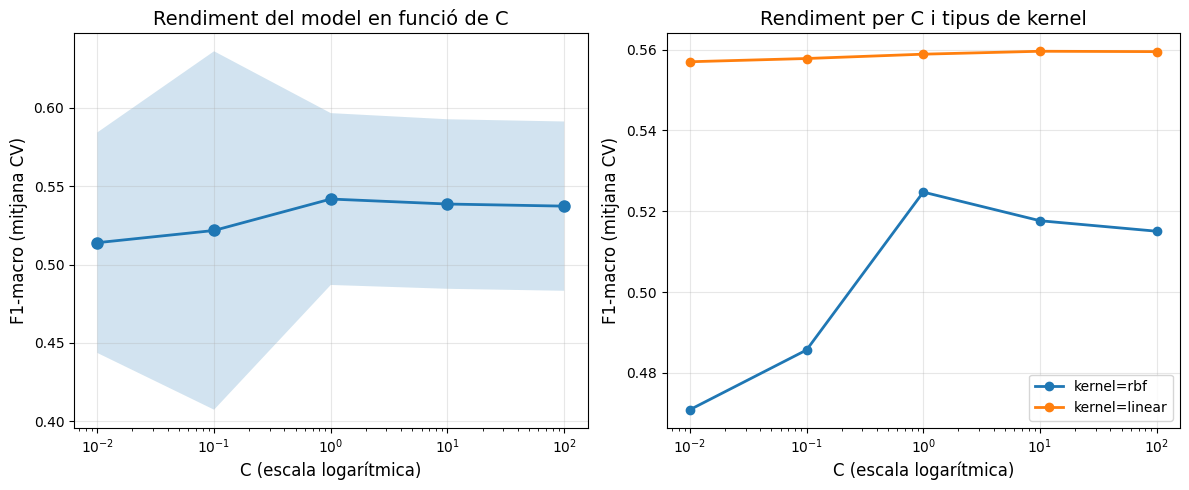

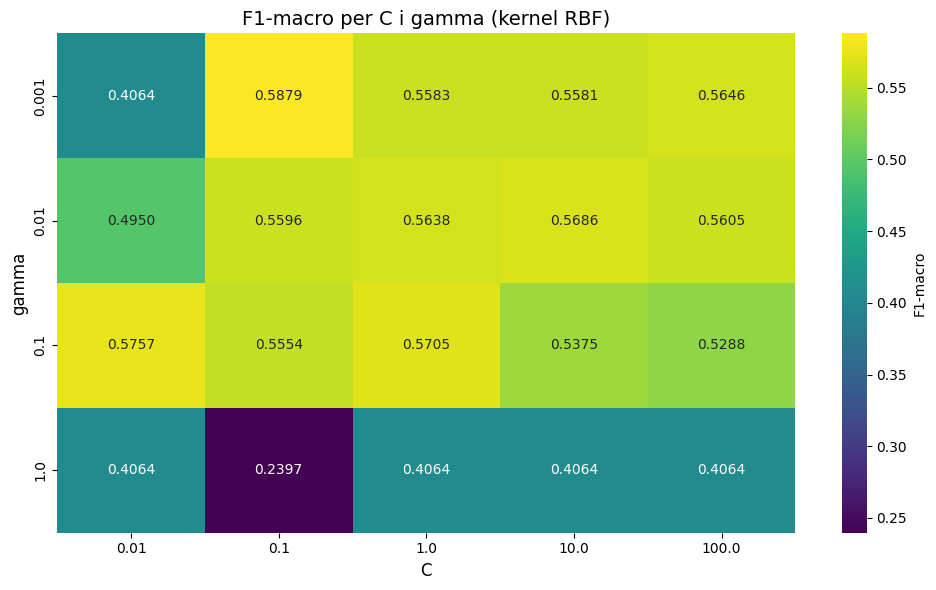


GRÀFICS GUARDATS: svm_performance_vs_C.png i svm_heatmap_C_gamma.png


In [10]:
# Extreure resultats de GridSearchCV
results_df = pd.DataFrame(grid_search.cv_results_)


# Agrupar per C i calcular la mitjana de F1-macro per cada valor de C
# (promitjant sobre diferents gamma i kernel)
f1_per_C = results_df.groupby('param_classifier__C')['mean_test_score'].agg(['mean', 'std', 'max'])


# Gràfic 1: F1-macro vs C (promig sobre tots els altres paràmetres)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
C_values = f1_per_C.index
plt.plot(C_values, f1_per_C['mean'], marker='o', linewidth=2, markersize=8)
plt.fill_between(C_values, 
                 f1_per_C['mean'] - f1_per_C['std'], 
                 f1_per_C['mean'] + f1_per_C['std'], 
                 alpha=0.2)
plt.xscale('log')
plt.xlabel('C (escala logarítmica)', fontsize=12)
plt.ylabel('F1-macro (mitjana CV)', fontsize=12)
plt.title('Rendiment del model en funció de C', fontsize=14)
plt.grid(True, alpha=0.3)

# Gràfic 2: F1-macro vs C separant per kernel
plt.subplot(1, 2, 2)
for kernel in results_df['param_classifier__kernel'].unique():
    kernel_data = results_df[results_df['param_classifier__kernel'] == kernel]
    kernel_f1_per_C = kernel_data.groupby('param_classifier__C')['mean_test_score'].mean()
    plt.plot(kernel_f1_per_C.index, kernel_f1_per_C.values, 
             marker='o', label=f'kernel={kernel}', linewidth=2, markersize=6)

plt.xscale('log')
plt.xlabel('C (escala logarítmica)', fontsize=12)
plt.ylabel('F1-macro (mitjana CV)', fontsize=12)
plt.title('Rendiment per C i tipus de kernel', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('svm_performance_vs_C.png', dpi=300, bbox_inches='tight')
plt.show()

# Gràfic 3: Heatmap per veure C vs gamma (només per kernel RBF)
rbf_results = results_df[results_df['param_classifier__kernel'] == 'rbf'].copy()
pivot_table = rbf_results.pivot_table(
    values='mean_test_score', 
    index='param_classifier__gamma', 
    columns='param_classifier__C'
)

plt.figure(figsize=(10, 6))
import seaborn as sns
sns.heatmap(pivot_table, annot=True, fmt='.4f', cmap='viridis', cbar_kws={'label': 'F1-macro'})
plt.title('F1-macro per C i gamma (kernel RBF)', fontsize=14)
plt.xlabel('C', fontsize=12)
plt.ylabel('gamma', fontsize=12)
plt.tight_layout()
plt.savefig('svm_heatmap_C_gamma.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("GRÀFICS GUARDATS: svm_performance_vs_C.png i svm_heatmap_C_gamma.png")
print("="*70)


## 6. Submission File

Generem el fitxer per entregar a la competició de Kaggle. Abans, es preprocessen totes les dades de `trs_eval` seguint la mateixa estratègia que per `trs_train`. Un copn tenim les dades preprocessades, generem el fitxer `submission_svm`.

In [11]:

# ============================================================================
# GENERACIÓ DEL FITXER DE SUBMISSION (SVM)
# ============================================================================

print("\n" + "=" * 80)
print("GENERANT SUBMISSION FILE - SVM")
print("=" * 80)

# 1. Carregar dades d'avaluació
try:
    test_df = pd.read_csv('trs_eval.csv')
    print(f"✓ Dades carregades: {test_df.shape}")
except FileNotFoundError:
    print("Error: No s'ha trobat el fitxer 'trs_eval.csv'.")
    raise

# 2. Guardar IDs per al fitxer final
if 'patient_id' in test_df.columns:
    patient_ids = test_df['patient_id']
else:
    print("Avís: No s'ha trobat 'patient_id'. Usant índex.")
    patient_ids = range(len(test_df))

# 3. Preparar les dades per al model
# IMPORTANT: Hem d'eliminar les mateixes variables que al train
variables_eliminar = ['patient_id', 'Glucose', 'Ki_whole_striatum', 
                      'Ki_associative_striatum', 'SUVRc_associative_striatum']

# Crear còpia per no modificar l'original
X_eval = test_df.copy()

# Eliminar variables (només les que existeixen)
cols_to_drop = [col for col in variables_eliminar if col in X_eval.columns]
if cols_to_drop:
    X_eval = X_eval.drop(columns=cols_to_drop)
    print(f"✓ Variables eliminades: {cols_to_drop}")

print(f"✓ Shape de les dades d'entrada al model: {X_eval.shape}")

# 4. Predicció amb el Pipeline SVM
# El pipeline (best_model) fa automàticament:
# - Imputació de missings (median per numèriques, most_frequent per categòriques)
# - One-Hot Encoding de variables categòriques
# - Escalat amb StandardScaler
# - Predicció amb SVM
try:
    y_pred_eval = best_model.predict(X_eval)
    print("✓ Prediccions generades correctament.")
    
except Exception as e:
    print(f"Error durant la predicció: {e}")
    print("Consell: Comprova que 'best_model' estigui definit i entrenat.")
    raise

# 5. Anàlisi de les prediccions (Sanity Check)
ratio_trs = y_pred_eval.mean()
print(f"\n--- Estadístiques de Predicció ---")
print(f"Total mostres: {len(y_pred_eval)}")
print(f"Prediccions TRS (1): {sum(y_pred_eval)} ({ratio_trs:.1%})")
print(f"Prediccions No-TRS (0): {len(y_pred_eval) - sum(y_pred_eval)} ({1-ratio_trs:.1%})")

if ratio_trs < 0.1 or ratio_trs > 0.5:
    print("ALERTA: La proporció de casos positius és inusualment baixa or alta.")
    print("(Revisa si és coherent amb la distribució del train)")

# 6. Crear DataFrame de sortida
submission = pd.DataFrame({
    'patient_id': patient_ids,
    'TRS': y_pred_eval
})

# 7. Guardar a CSV
filename = 'submission_svm.csv'
submission.to_csv(filename, index=False)

print("\n" + "=" * 80)
print(f"✓ FITXER CREAT AMB ÈXIT: {filename}")
print("=" * 80)

# Mostra les primeres i últimes files per verificar
print("\nPrimeres 10 files:")
print(submission.head(10))
print("\nÚltimes 5 files:")
print(submission.tail())
print(f"\nTotal files al submission: {len(submission)}")



GENERANT SUBMISSION FILE - SVM
✓ Dades carregades: (1000, 27)
✓ Variables eliminades: ['patient_id', 'Glucose', 'Ki_whole_striatum', 'Ki_associative_striatum', 'SUVRc_associative_striatum']
✓ Shape de les dades d'entrada al model: (1000, 22)
✓ Prediccions generades correctament.

--- Estadístiques de Predicció ---
Total mostres: 1000
Prediccions TRS (1): 299 (29.9%)
Prediccions No-TRS (0): 701 (70.1%)

✓ FITXER CREAT AMB ÈXIT: submission_svm.csv

Primeres 10 files:
   patient_id  TRS
0           1    1
1           2    0
2           3    0
3           4    0
4           5    0
5           6    0
6           7    0
7           8    0
8           9    1
9          10    0

Últimes 5 files:
     patient_id  TRS
995         996    0
996         997    0
997         998    1
998         999    0
999        1000    0

Total files al submission: 1000
